In [24]:
import rosbag
from geometry_msgs.msg import Vector3
import rospy
from crazyflie_msgs.msg import CrazyflieLog
import numpy as np
import matplotlib.pyplot as plt
import tf.transformations as tf

bag = rosbag.Bag('/home/miguel/catkin_ws/src/crazyflie/crazyflie_controller/src/data/balanced_04_vel20.bag')

time = []
position_kalman = []
vel_kalmam = []
position_optitrack = []
orientation_optitrack = []
vel_optitrack = []
vel_crazyflie = []
thrust_crazyflie = []
pitch_roll_crazyflie = []
yaw_angle_crazyflie = []
z_crazyflie = []
reference_vel = []
desired_position = []
desired_velocity = []

for topic, msg, t in bag.read_messages(topics=['time', 'position_Optitrack', 'position_estimate_topic', 'vel_Optitrack', 'vel_estimate_topic', 'crazyflieLog', 'optitrack_pose', 'reference_vel', 'desired_position', 'desired_vel']):
    if topic == 'time':
        time.append(msg.data)

    if topic == 'vel_Optitrack':
        vel_optitrack.append((msg.x, msg.y, msg.z))

    if topic == 'position_estimate_topic':
        position_kalman.append((msg.x, msg.y, msg.z))

    if topic == 'vel_estimate_topic':
        vel_kalmam.append((msg.x, msg.y, msg.z))

    if topic == 'optitrack_pose':
        position_optitrack.append((msg.pose.position.x, msg.pose.position.y, msg.pose.position.z))
        orientation_optitrack.append((msg.pose.orientation.x, msg.pose.orientation.y, msg.pose.orientation.z, msg.pose.orientation.w))

    if topic == 'crazyflieLog':
        vel_crazyflie.append((msg.vx, msg.vy, msg.vz))
        thrust_crazyflie.append(msg.thrust)
        pitch_roll_crazyflie.append((msg.roll, -msg.pitch))
        yaw_angle_crazyflie.append(msg.yaw)
        z_crazyflie.append(msg.z)

    if topic == 'reference_vel':
        reference_vel.append((msg.x, msg.y, msg.z))

    if topic == 'desired_position':
        desired_position.append((msg.x, msg.y, msg.z))
    
    if topic == 'desired_vel':
        desired_velocity.append((msg.x, msg.y, msg.z))

## Limit the data between 5 and 25 seconds
start = 5
end = 20

len_time = len(time)
max_time = time[len_time-1]

start_index = int(start*len_time/max_time)
end_index = int(end*len_time/max_time)

time = np.array(time[start_index:end_index])
position_kalman = np.array(position_kalman[start_index:end_index])
vel_kalmam = np.array(vel_kalmam[start_index:end_index])
position_optitrack = np.array(position_optitrack[start_index:end_index])
orientation_optitrack = np.array(orientation_optitrack[start_index:end_index])
vel_optitrack = np.array(vel_optitrack[start_index:end_index])
vel_crazyflie = np.array(vel_crazyflie[start_index:end_index])
thrust_crazyflie = np.array(thrust_crazyflie[start_index:end_index])
pitch_roll_crazyflie = np.array(pitch_roll_crazyflie[start_index:end_index])
yaw_angle_crazyflie = np.array(yaw_angle_crazyflie[start_index:end_index])
z_crazyflie = np.array(z_crazyflie[start_index:end_index])
reference_vel = np.array(reference_vel[start_index:end_index])
desired_position = np.array(desired_position[start_index:end_index])
desired_velocity = np.array(desired_velocity[start_index:end_index])

### Rotation Matricies

In [25]:
def rotation_body_to_world(orientation, vector):
    R = np.array([[np.cos(orientation) , -np.sin(orientation)], 
                  [np.sin(orientation) , np.cos(orientation)]])
    return np.dot(R, vector)

def rotation_world_to_body(orientation, vector):
    R = np.array([[np.cos(orientation) , np.sin(orientation)], 
                  [-np.sin(orientation), np.cos(orientation)]])
    return np.dot(R, vector)

In [26]:
### Rotation matricies
orientation_optitrack_rad = np.array([tf.euler_from_quaternion(orientation) for orientation in orientation_optitrack])

orientation_crazyflie_rad = np.zeros((len(time), 3))
orientation_crazyflie_rad[:, 0:2] = pitch_roll_crazyflie
orientation_crazyflie_rad[:, 2] = yaw_angle_crazyflie
orientation_crazyflie_rad = np.deg2rad(orientation_crazyflie_rad)

vel_crazyflie_body = np.zeros((len(time), 3))
vel_optitrack_body = np.zeros((len(time), 3))

for i in range(len(time)):
    vel_crazyflie_body[i, 0:2] = rotation_world_to_body(orientation_crazyflie_rad[i, 2], vel_crazyflie[i, 0:2])
    vel_crazyflie_body[i, 2] = vel_crazyflie[i, 2]

    vel_optitrack_body[i, 0:2] = rotation_world_to_body(orientation_optitrack_rad[i, 2], vel_optitrack[i, 0:2])
    vel_optitrack_body[i, 2] = vel_optitrack[i, 2]

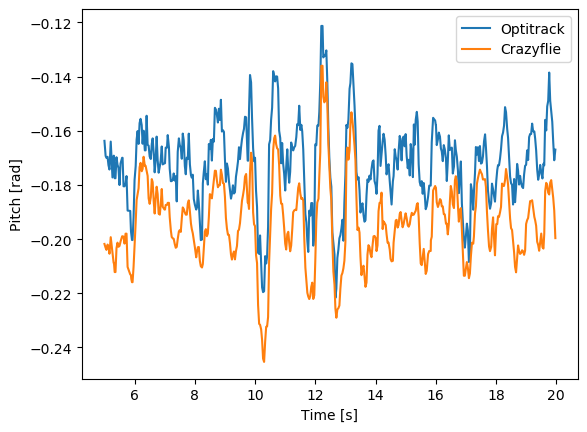

In [27]:
plt.plot(time, np.array(orientation_optitrack_rad)[:, 0], label='Optitrack')
plt.plot(time, orientation_crazyflie_rad[:, 0], label='Crazyflie')

plt.xlabel('Time [s]')
plt.ylabel('Pitch [rad]')
plt.legend()
plt.show()

# reference vel traking

## World frame

### Velocity X

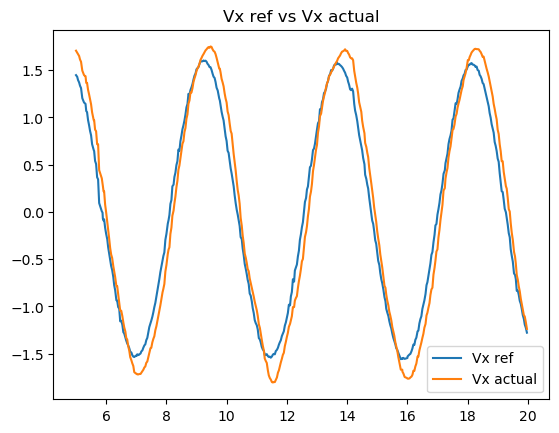

In [28]:
### Reverence velocity vs actual velocity
reference_vel = np.array(reference_vel)
vel_crazyflie = np.array(vel_crazyflie)
vel_optitrack = np.array(vel_optitrack)

rad_yaw = np.array(yaw_angle_crazyflie) * np.pi / 180

rotated_reference_vel = np.zeros((len(time), 3))

### Rotate reference velocity x and y to the body frame
for i in range(len(time)):
    R = np.array([[np.cos(rad_yaw[i]), -np.sin(rad_yaw[i])], [np.sin(rad_yaw[i]), np.cos(rad_yaw[i])]])
    rotated_reference_vel[i,0:2] = np.dot(R, reference_vel[i,0:2])

rotated_reference_vel[:,2] = reference_vel[:,2]

plt.figure()
plt.plot(time, rotated_reference_vel[:,0], label='Vx ref')
plt.plot(time, vel_crazyflie[:,0], label='Vx actual')
# plt.plot(time, vel_optitrack[:,0], label='Vx optitrack')

plt.legend()
plt.title('Vx ref vs Vx actual')
plt.show()

# Drone frame

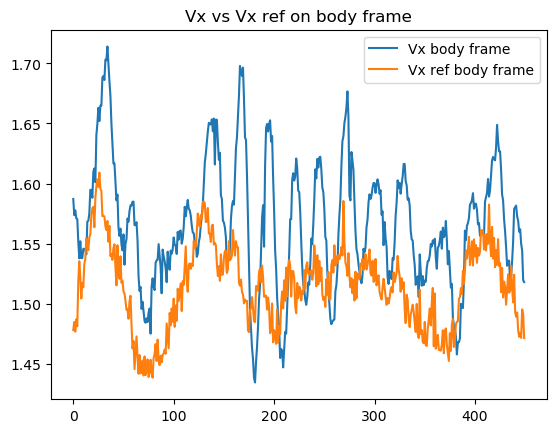

In [29]:
rotated_velocities = []

# Convert quaternion to euler angles in degrees
orientation = [tf.euler_from_quaternion(orientation) for orientation in orientation_optitrack]

for i in range(len(vel_crazyflie)):
    yaw_angle = orientation[i][2]
    rotated_velocities.append((vel_crazyflie[i][0] * np.cos(yaw_angle) + vel_crazyflie[i][1] * np.sin(yaw_angle), -vel_crazyflie[i][0] * np.sin(yaw_angle) + vel_crazyflie[i][1] * np.cos(yaw_angle), vel_crazyflie[i][2]))


plt.figure()
plt.plot(range(len(rotated_velocities)), [x[0] for x in rotated_velocities], label='Vx body frame')
plt.plot(range(len(reference_vel)), [x[0] for x in reference_vel], label='Vx ref body frame')

plt.legend()
plt.title('Vx vs Vx ref on body frame') 

plt.show()

### Velocity y

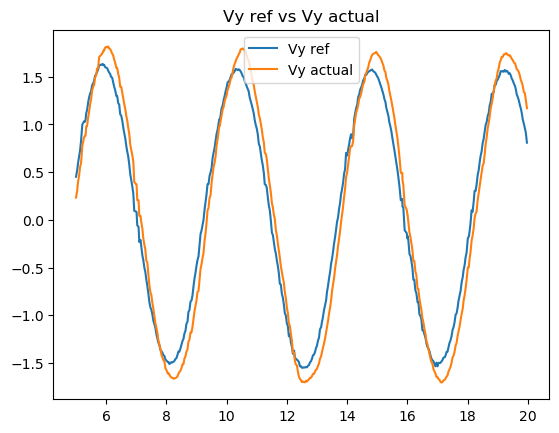

In [30]:
plt.figure()
plt.plot(time, rotated_reference_vel[:,1], label='Vy ref')
plt.plot(time, vel_crazyflie[:,1], label='Vy actual')
plt.legend()
plt.title('Vy ref vs Vy actual')
plt.show()

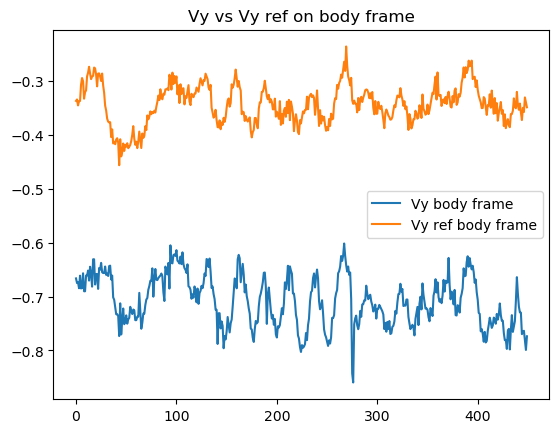

In [31]:
plt.figure()
plt.plot(range(len(rotated_velocities)), [x[1] for x in rotated_velocities], label='Vy body frame')
plt.plot(range(len(reference_vel)), [x[1] for x in reference_vel], label='Vy ref body frame')

plt.legend()
plt.title('Vy vs Vy ref on body frame') 

plt.show()

### Velocity Z

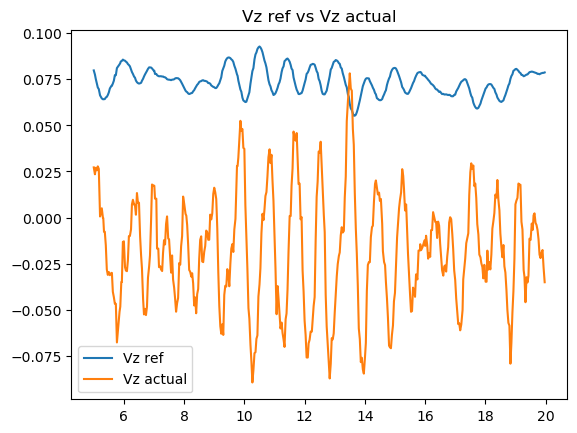

In [32]:
plt.figure()
plt.plot(time, rotated_reference_vel[:,2], label='Vz ref')
plt.plot(time, vel_crazyflie[:,2], label='Vz actual')
plt.legend()
plt.title('Vz ref vs Vz actual')
plt.show()

# Velocity tracking error

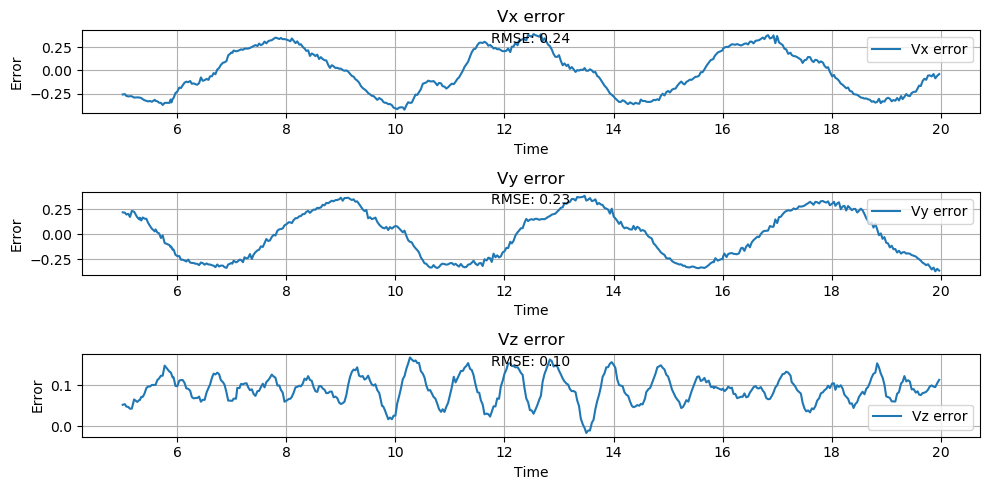

In [33]:
### Reference velocity vs actual velocity error
error_vel = rotated_reference_vel - vel_crazyflie

### RMSE
rmse = np.sqrt(np.mean(error_vel**2, axis=0))

plt.figure(figsize=(10, 5))

plt.subplot(3, 1, 1)
plt.plot(time, error_vel[:,0], label='Vx error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Vx error')

x_position = 0.5
y_position = 0.9
plt.text(x_position, y_position, f'RMSE: {rmse[0]:.2f}', transform=plt.gca().transAxes, ha='center', va='center')

plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, error_vel[:,1], label='Vy error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Vy error')
plt.text(x_position, y_position, f'RMSE: {rmse[1]:.2f}', transform=plt.gca().transAxes, ha='center', va='center')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, error_vel[:,2], label='Vz error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Vz error')
plt.text(x_position, y_position, f'RMSE: {rmse[2]:.2f}', transform=plt.gca().transAxes, ha='center', va='center')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Position error

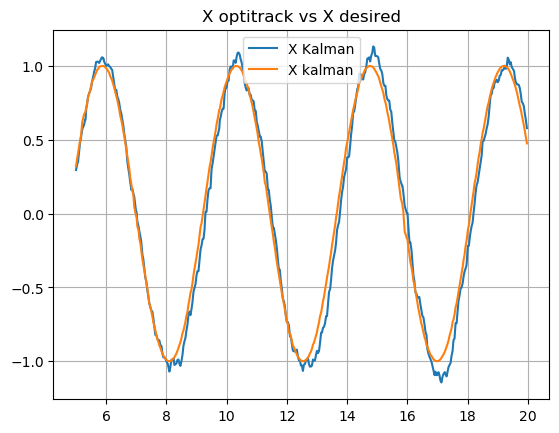

In [34]:
position_optitrack = np.array(position_kalman)
desired_position = np.array(desired_position)

plt.figure()
plt.plot(time, position_optitrack[:,0], label='X Kalman')
plt.plot(time, desired_position[:,0], label='X kalman')
plt.legend()
plt.title('X optitrack vs X desired')
plt.grid(True)
plt.show()


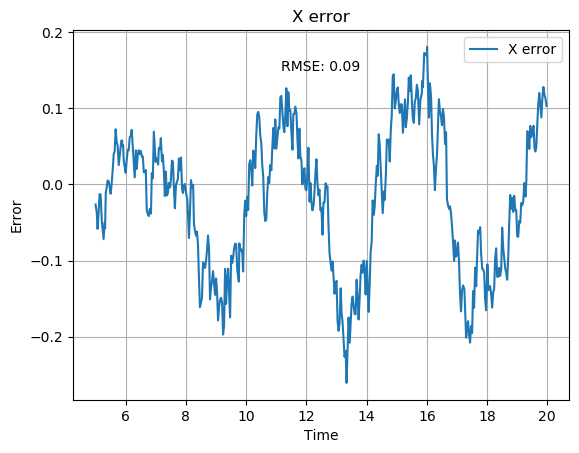

In [35]:
position_error = np.array(position_optitrack) - np.array(desired_position)
rmse_position = np.sqrt(np.mean(position_error**2, axis=0))

plt.figure()
plt.plot(time, position_error[:,0], label='X error')
plt.xlabel('Time')
plt.ylabel('Error')
plt.text(x_position, y_position, f'RMSE: {rmse_position[0]:.2f}', transform=plt.gca().transAxes, ha='center', va='center')
plt.legend()
plt.title('X error')
plt.grid(True)
plt.show()

## Optitrack vs Crazyflie angles

### Row

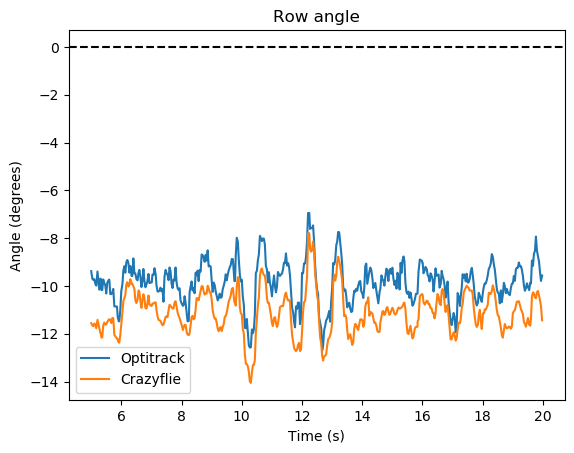

In [36]:
# Convert quaternion to euler angles in degrees
orientation_degrees = [tf.euler_from_quaternion(orientation) for orientation in orientation_optitrack]
orientation_degrees = [[angle * 180 / np.pi for angle in angles] for angles in orientation_degrees]

plt.plot(time, [x[0] for x in orientation_degrees])
plt.plot(time, [x[0] for x in pitch_roll_crazyflie])
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Row angle')
plt.legend(['Optitrack', 'Crazyflie'])
plt.axhline(y=0.0, color='k', linestyle='--')

plt.show()

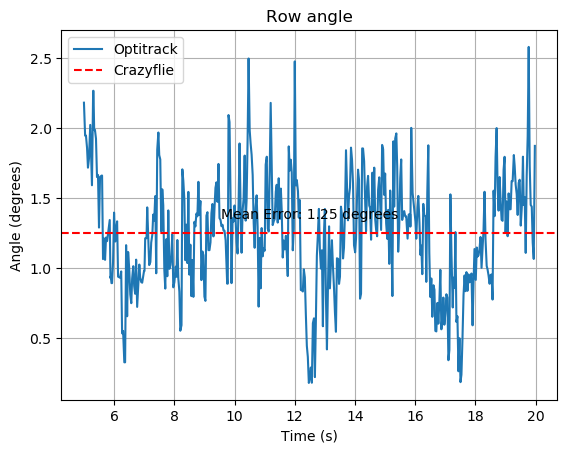

In [37]:
## Row error
row_optitrack = np.array([x[0] for x in orientation_degrees])
row_crazyflie = np.array([x[0] for x in pitch_roll_crazyflie])

row_error = row_optitrack - row_crazyflie

# plot row error
plt.figure()
plt.plot(time, row_error)
mean_error = np.mean(row_error)
plt.axhline(y=mean_error, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Row angle')
plt.legend(['Optitrack', 'Crazyflie', f'Mean Error: {mean_error:.2f}'])
plt.text(0.5, 0.5, f'Mean Error: {mean_error:.2f} degrees', transform=plt.gca().transAxes, ha='center', va='center')
plt.grid(True)
plt.show()

### Pitch

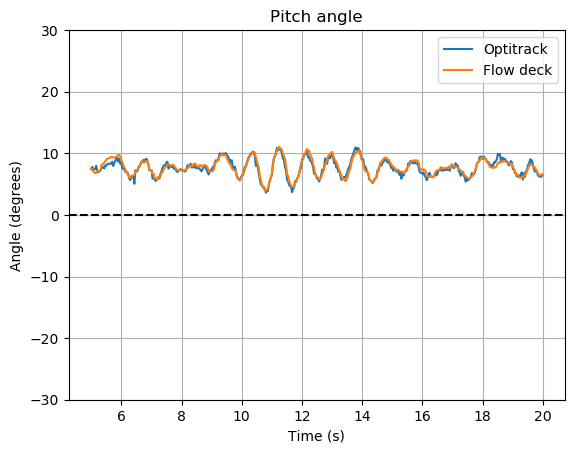

In [38]:
plt.plot(time, [x[1] for x in orientation_degrees])
plt.plot(time, [x[1] for x in pitch_roll_crazyflie])
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Pitch angle')
plt.legend(['Optitrack', 'Flow deck'])
plt.grid(True)
plt.ylim(-30, 30)
plt.axhline(y=0.0, color='k', linestyle='--')

plt.show()

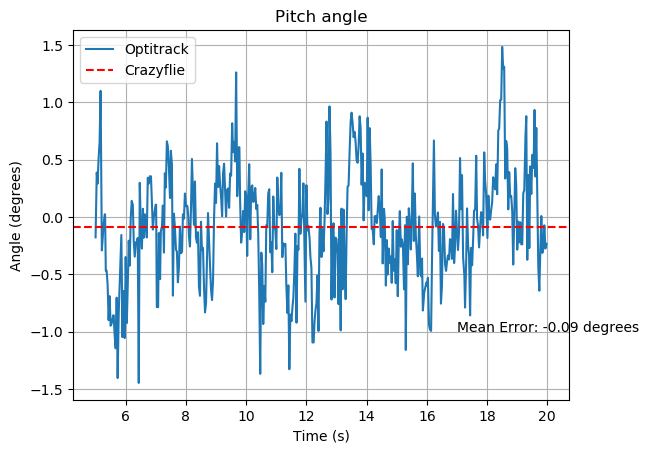

In [39]:
## Pitch error
pitch_optitrack = np.array([x[1] for x in orientation_degrees])
pitch_crazyflie = np.array([x[1] for x in pitch_roll_crazyflie])

pitch_error = pitch_optitrack - pitch_crazyflie

# plot pitch error
plt.figure()
plt.plot(time, pitch_error)
mean_error = np.mean(pitch_error)
plt.axhline(y=mean_error, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Pitch angle')
plt.legend(['Optitrack', 'Crazyflie'])

x_position = 17
y_position = -1.0
plt.text(x_position, y_position, f'Mean Error: {mean_error:.2f} degrees')
plt.grid(True)
plt.show()

### Yaw

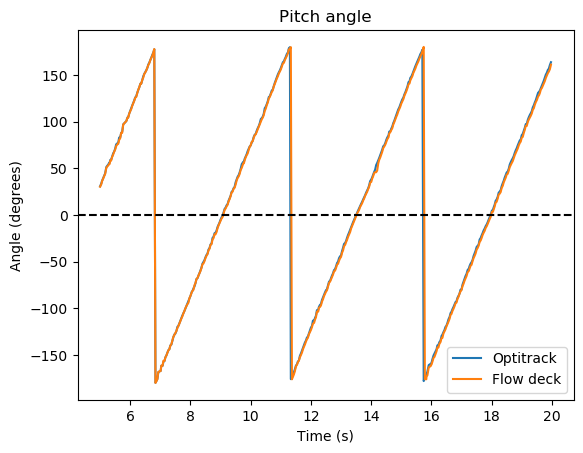

In [40]:
plt.plot(time, [x[2] for x in orientation_degrees])
plt.plot(time, yaw_angle_crazyflie)
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Pitch angle')
plt.legend(['Optitrack', 'Flow deck'])
plt.axhline(y=0.0, color='k', linestyle='--')

plt.show()

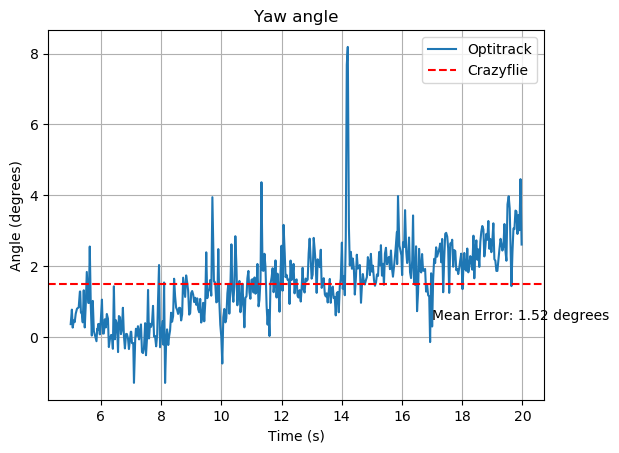

In [41]:
### Yaw error
yaw_optitrack = np.array([x[2] for x in orientation_degrees])
yaw_crazyflie = np.array(yaw_angle_crazyflie)

yaw_error = yaw_optitrack - yaw_crazyflie

### Taking off outliers
for i in range(len(yaw_error)):
    if abs(yaw_error[i]) > 180:
        yaw_error[i] = yaw_error[i] + 360

# plot yaw error
plt.figure()
plt.plot(time, yaw_error)
mean_error = np.mean(yaw_error)
plt.axhline(y=mean_error, color='r', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Yaw angle')
plt.legend(['Optitrack', 'Crazyflie', f'Mean Error: {mean_error:.2f}'])

x_position = 17
y_position = 0.5
plt.text(x_position, y_position, f'Mean Error: {mean_error:.2f} degrees')
plt.grid(True)
plt.show()

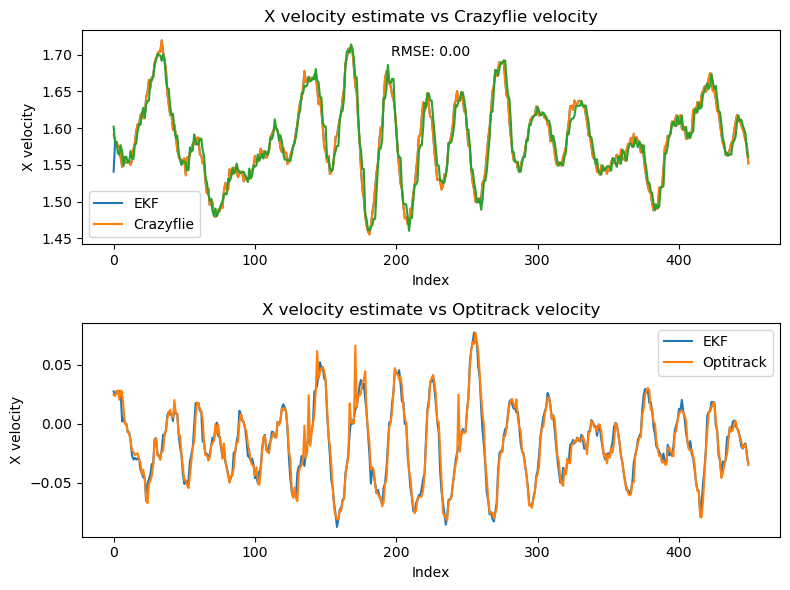

In [42]:
import numpy as np
import sympy as sp

class ExtendedKalmanFilter:
    def __init__(self, initial_state, initial_error_covariance, dt, m, Kvx, Kvy, Kvz, Rw, Rv):
        # Symbolic variables for state and control input
        self.x, self.y, self.z, self.x_dot_body, self.y_dot_body, self.z_dot_body = sp.symbols('x y z x_dot_body y_dot_body z_dot_body')
        self.theta, self.phi, self.psi, self.t = sp.symbols('theta phi psi t')

        # State and control input as NumPy arrays
        self.state_estimate = np.array(initial_state)
        self.error_covariance = np.array(initial_error_covariance)

        # Constants and time step
        self.dt = dt
        self.m = m
        self.g = 9.81
        self.Kvx = Kvx
        self.Kvy = Kvy
        self.Kvz = Kvz

        # Process and measurement noise covariance matrices
        self.Rw = np.array(Rw)
        self.Rv = np.array(Rv)

        # Precompute the symbolic state transition function and its Jacobian
        self._precompute_dynamics()

    def _precompute_dynamics(self):
        # Define the symbolic state transition equations
        state = sp.Matrix([self.x, self.y, self.z, self.x_dot_body, self.y_dot_body, self.z_dot_body])
        control_input = sp.Matrix([self.theta, self.phi, self.psi, self.t])

        # World frame dynamics
        x_world = sp.cos(self.psi) * self.x_dot_body - sp.sin(self.psi) * self.y_dot_body
        y_world = sp.sin(self.psi) * self.x_dot_body + sp.cos(self.psi) * self.y_dot_body
        z_world = self.z_dot_body
        x_ddot_w = -self.Kvx / self.m * self.x_dot_body + self.t / self.m * sp.sin(self.theta)
        y_ddot_w = -self.Kvy / self.m * self.y_dot_body + self.t / self.m * sp.sin(self.phi)
        z_ddot_w = -self.Kvz / self.m * self.z_dot_body + self.t / self.m * sp.cos(self.theta) * sp.cos(self.phi) - self.g

        # State transition equations
        new_state = sp.Matrix([
            self.x + x_world * self.dt,
            self.y + y_world * self.dt,
            self.z + z_world * self.dt,
            self.x_dot_body + x_ddot_w * self.dt,
            self.y_dot_body + y_ddot_w * self.dt,
            self.z_dot_body + z_ddot_w * self.dt
        ])

        # Compute the Jacobian matrix of the state transition function
        self.jacobian_func = sp.lambdify((state, control_input), new_state.jacobian(state), 'numpy')

    def update(self, measurement, control_input):
        # Prediction
        control_input_np = np.array(control_input, dtype=float)
        jacobian_matrix = self.jacobian_func(self.state_estimate, control_input_np)

        # State transition (numerical computation)
        self.state_estimate = self._state_transition(self.state_estimate, control_input_np)
        self.error_covariance = jacobian_matrix @ self.error_covariance @ jacobian_matrix.T + self.Rw

        # Update
        H = np.eye(6)  # Measurement matrix
        innovation = measurement - H @ self.state_estimate
        innovation_covariance = H @ self.error_covariance @ H.T + self.Rv
        kalman_gain = self.error_covariance @ H.T @ np.linalg.pinv(innovation_covariance)
        self.state_estimate = self.state_estimate + kalman_gain @ innovation
        self.error_covariance = (np.eye(6) - kalman_gain @ H) @ self.error_covariance

        return self.state_estimate, kalman_gain

    def _state_transition(self, state, control_input):
        # Unpack the state and control input
        x, y, z, x_dot_body, y_dot_body, z_dot_body = state
        theta, phi, psi, t = control_input

        # Calculate the world frame dynamics
        x_world = np.cos(psi) * x_dot_body - np.sin(psi) * y_dot_body
        y_world = np.sin(psi) * x_dot_body + np.cos(psi) * y_dot_body
        z_world = z_dot_body
        x_ddot_w = -self.Kvx / self.m * x_dot_body + t / self.m * np.sin(theta)
        y_ddot_w = -self.Kvy / self.m * y_dot_body + t / self.m * np.sin(phi)
        z_ddot_w = -self.Kvz / self.m * z_dot_body + t / self.m * np.cos(theta) * np.cos(phi) - self.g

        # State transition
        new_state = np.array([
            x + x_world * self.dt,
            y + y_world * self.dt,
            z + z_world * self.dt,
            x_dot_body + x_ddot_w * self.dt,
            y_dot_body + y_ddot_w * self.dt,
            z_dot_body + z_ddot_w * self.dt
        ])

        return new_state

# Define the initial state and error covariance
initial_state = [0, 0, 0, 0, 0, 0]
initial_error_covariance = np.eye(6) * 0.1

# Define the process and measurement noise covariance matrices
Rw = np.diag([0.01, 0.01, 0.01, 0.2, 0.2, 0.2])  # Process noise covariance
Rv = np.diag([0.8, 0.8, 0.01, 0.01, 0.01, 0.01])  # Measurement noise covariance

# Create the EKF
ekf = ExtendedKalmanFilter(initial_state, initial_error_covariance, 1/30, 0.035, 0.03, 0.03, 0.0, Rw, Rv)

# Define the control input and measurement
a_max = 14.3
conversao_digital = 60000/a_max

# Define the control input and measurement
m = 0.035
g = 9.81
thrust = (np.array(thrust_crazyflie)*m - g) / conversao_digital

state_estimate_ = []
position_with_noise = []
for i in range(len(vel_crazyflie)):

    control_input = [orientation_crazyflie_rad[i, 1], orientation_crazyflie_rad[i, 0], orientation_crazyflie_rad[i, 2], thrust[i]]

    noise = 0.2
    measurement = [
        position_optitrack[i][0] + np.random.normal(0, noise),
        position_optitrack[i][1] + np.random.normal(0, noise),
        position_optitrack[i][2],
        vel_crazyflie_body[i][0],
        vel_crazyflie_body[i][1],
        vel_crazyflie_body[i][2]
    ]

    position_with_noise.append(measurement[:3])

    # Update the EKF
    state_estimate, kalman_gain = ekf.update(measurement, control_input)
    state_estimate_.append(state_estimate)

# Plot the estimated state
state_estimate_ = np.array(state_estimate_)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot X velocity estimate
ax1.plot(range(len(state_estimate_)), state_estimate_[:, 3])
ax1.plot(range(len(vel_crazyflie_body)), [x[0] for x in vel_crazyflie_body])
ax1.plot(range(len(vel_kalmam)), [x[0] for x in vel_kalmam])

### cALCULATE rmse 
rmse = np.sqrt(np.mean((state_estimate_[:, 3] - [x[0] for x in vel_crazyflie_body])**2))

x_position = 0.5
y_position = 0.9
ax1.text(x_position, y_position, f'RMSE: {rmse:.2f}', transform=ax1.transAxes, ha='center', va='center')
ax1.set_xlabel('Index')
ax1.set_ylabel('X velocity')
ax1.set_title('X velocity estimate vs Crazyflie velocity')
ax1.legend(['EKF', 'Crazyflie'])

# Plot Y velocity estimate
ax2.plot(range(len(state_estimate_)), state_estimate_[:, 5])
ax2.plot(range(len(vel_optitrack_body)), [x[2] for x in vel_optitrack_body])
ax2.set_xlabel('Index')
ax2.set_ylabel('X velocity')
# ax2.set_ylim(-1.5, 1.5)
ax2.set_title('X velocity estimate vs Optitrack velocity')
ax2.legend(['EKF', 'Optitrack'])

plt.tight_layout()
plt.show()

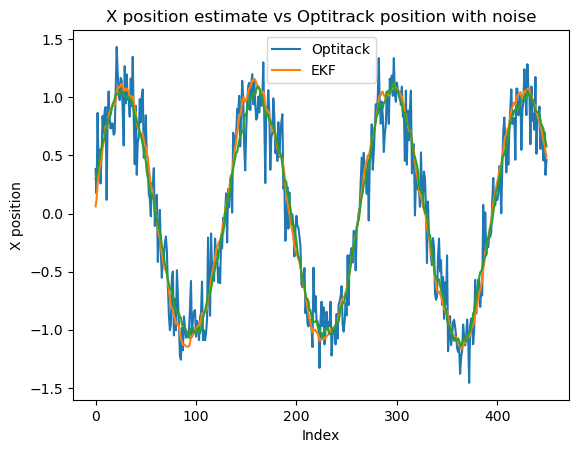

In [43]:
state_estimate_ = np.array(state_estimate_)
plt.plot(range(len(position_with_noise)), [x[0] for x in position_with_noise])
plt.plot(range(len(state_estimate_)), state_estimate_[:, 0])
plt.plot(range(len(position_kalman)), [x[0] for x in position_kalman])

# plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.xlabel('Index')
plt.ylabel('X position')
plt.title('X position estimate vs Optitrack position with noise')
plt.legend(['Optitack', 'EKF'])
plt.show()


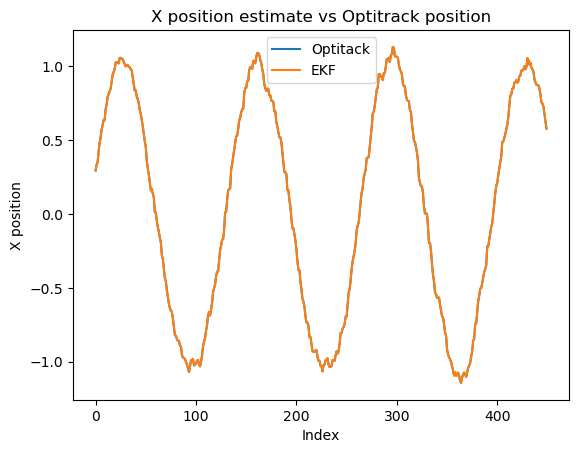

In [44]:
state_estimate_ = np.array(state_estimate_)
plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
# plt.plot(range(len(state_estimate_)), state_estimate_[:, 0])
plt.plot(range(len(position_kalman)), [x[0] for x in position_kalman])

# plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.xlabel('Index')
plt.ylabel('X position')
plt.title('X position estimate vs Optitrack position')
plt.legend(['Optitack', 'EKF'])
plt.show()

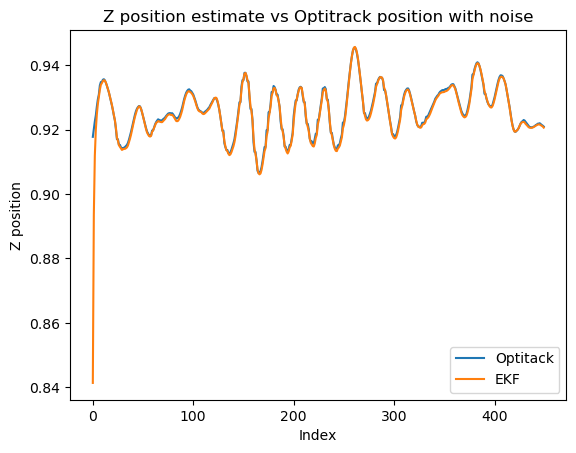

In [45]:
state_estimate_ = np.array(state_estimate_)
plt.plot(range(len(position_with_noise)), [x[2] for x in position_with_noise])
plt.plot(range(len(state_estimate_)), state_estimate_[:, 2])

# plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.xlabel('Index')
plt.ylabel('Z position')
plt.title('Z position estimate vs Optitrack position with noise')
plt.legend(['Optitack', 'EKF'])
plt.show()


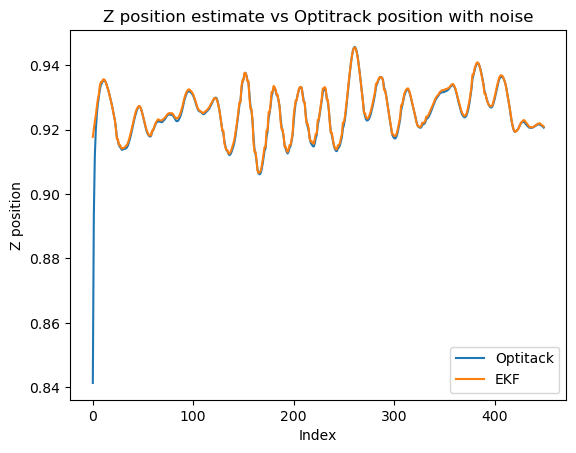

In [46]:
state_estimate_ = np.array(state_estimate_)
plt.plot(range(len(state_estimate_)), state_estimate_[:, 2])
plt.plot(range(len(position_optitrack)), [x[2] for x in position_optitrack])

# plt.plot(range(len(position_kalman)), [x[0] for x in position_kalman])

# plt.plot(range(len(position_optitrack)), [x[0] for x in position_optitrack])
plt.xlabel('Index')
plt.ylabel('Z position')
plt.title('Z position estimate vs Optitrack position with noise')
plt.legend(['Optitack', 'EKF', 'Kalman'])
plt.show()
